[Model is outdated] Compare the results of using k = 5 and k = 7. The notebook tries out the following three models:

* kmeans = 5 with target encoded sequences >> ~0.62**  
* kmeans = 7 with target encoded sequences >> ~0.60  
* kmeans = 7 with onehot encoded sequences >> ~0.55

Higher `k` is used in hope of having fewer centroids in each cluser. However, it does not help much. Big clusters remain big and there are more small clusters.

See feature importance at the end.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from interpolation import CensusData, sequences, BlockInterpolator, CentroidInterpolator, archive, interpolation
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


### prepare data

In [2]:
#Change these values to rerun the notebook
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v01.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_XYupdate.csv") #For calculating centroids
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
ward_col = "Ward_Num"
dwelling_col = "dwelling_id"
dwelling_col_num = "CENSUS_DWELLING_NUM"
block_col = "block_num"
x_col = "cd_X"
y_col = "cd_Y"
pagenum = "CENSUS_PAGENNO"

In [3]:
print(filled_1850.shape)
print(filled_1850.loc[~filled_1850['block_num'].isnull()].shape)
print(filled_1850.loc[filled_1850['block_num'].isnull()].shape)

(515630, 32)
(166500, 32)
(349130, 32)


In [4]:
#set clustering algo -- this is to make sure that the same clustering algorithm is used
#for each model, to ensure that testing is accurate
#note fitting before hand won't work for all types of clustering, for example, with agglomerative
#clustering this isn't going to work because the algorithm doesn't have a predict method
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}

In [5]:
enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_ward10.csv")

In [6]:
ward10 = filled_1850[filled_1850[ward_col] == 10]
ward10_enumerators = ward10.merge(enumerators,  how = "left", left_on= "CENSUS_PAGENUM", right_on = "CENSUS_PAGENO_HOUSEHOLD")

In [7]:
census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, fixed = True, distance = True)

In [8]:
similar_cols = ["sequence_id", "dwelling_seq_id", "fixed_seq", "enum_dist_id"]
census_enum_seq.apply_similarity(sim_columns=similar_cols)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 24272.0


In [9]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
            "enum_dist_order"]

transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
                                              ('onehot', OneHotEncoder(handle_unknown='ignore'), ['similarity_label'])])
# define pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), 
                           ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                       n_estimators = 50))])

# k=5

n is 5 and it's the 10th iteration
n is 5 and it's the 20th iteration
n is 5 and it's the 30th iteration
n is 5 and it's the 40th iteration
n is 5 and it's the 50th iteration


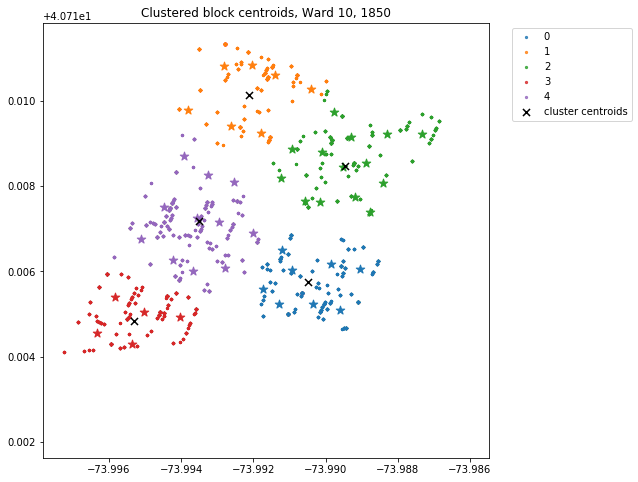

In [10]:
interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols + ['similarity_label'],
                                             KMeans(5), block_centroids)
score, model = interpolate_sequences.kmeans_best(5)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
interpolate_sequences.clustervis(kmeans = True)

In [11]:
## retrain model using kmodes result

interpolate_sequences.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
print('Test score:', interpolate_sequences.test_score)
print("avg Test score:", np.array(interpolate_sequences.test_score).mean())

Cross Validation
avg Training score: 0.9798513322867727
Test score: [0.5743631881676253, 0.6576419213973799, 0.6669588080631026, 0.5156912637828668, 0.6187845303867403, 0.7291479820627803, 0.6260387811634349, 0.5724876441515651, 0.5838680109990834, 0.6152241918665277]
avg Test score: 0.6160206322041105


### Refit the model using this setting (no CV) [CV score of the model is 0.62]

The results from here are used for further analysis.

In [12]:
train,test = interpolate_sequences.stratified_train_test()
interpolate_sequences.train_test_model(train, test)

In [13]:
print("Training score:",interpolate_sequences.train_score)
print("Test score:", interpolate_sequences.test_score)

Training score: 0.9835355285961872
Test score: 0.5743631881676253


In [14]:
test['pred_cluster'] = interpolate_sequences.model.predict(test)

In [19]:
def plot_predictions(cluster_of_centroid, ward, cluster, test_df, title=None):
    #colors = [color for color, i in zip(mcolors.CSS4_COLORS.values(), range(len(np.unique(self.clusters)))) if i < len(np.unique(self.clusters))]
    colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][x] for x in range(len(np.unique(cluster_of_centroid)))]
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    color = colors[0]

    # for cluster, color in zip(np.unique(cluster_of_centroid), colors):
        # get cluster data
    X_subset = test_df[test_df["pred_cluster"] == cluster]
    centroids_subset = np.array(list(block_centroids[ward].values()))[cluster_of_centroid == cluster]

    # graph info
    ax.scatter(x=test_df.loc[:, x_col], y=test_df.loc[:, y_col], s=1, alpha=0.1,
               color='grey')
    for clus, co in zip(np.unique(cluster_of_centroid), colors):
        if clus == cluster:
            size = 50
        else:
            size = 20
        X_subset_2 = X_subset[X_subset["cluster"] == clus]
        ax.scatter(x=X_subset_2.loc[:, x_col], y=X_subset_2.loc[:, y_col], 
                   s=size, alpha=0.1, label=str(clus),
                   color=co)
    #     ax.scatter(centroids_subset[:, 0], centroids_subset[:, 1], marker="*", s=80, color=co)
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title("Clustered block centroids, Ward {}, 1850".format(ward))

    ax.legend(bbox_to_anchor = (1.04, 1), loc = "upper left")
    plt.show()

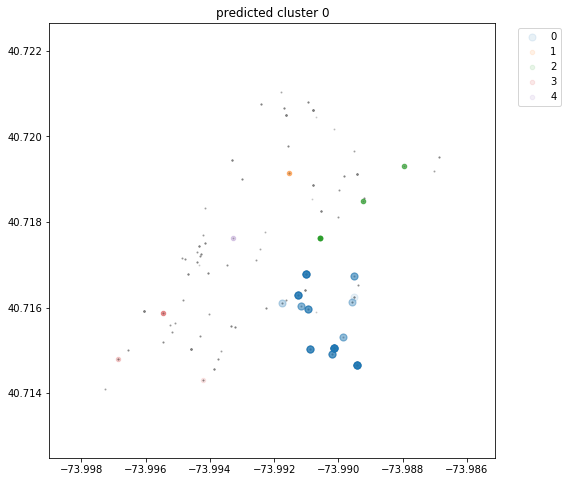

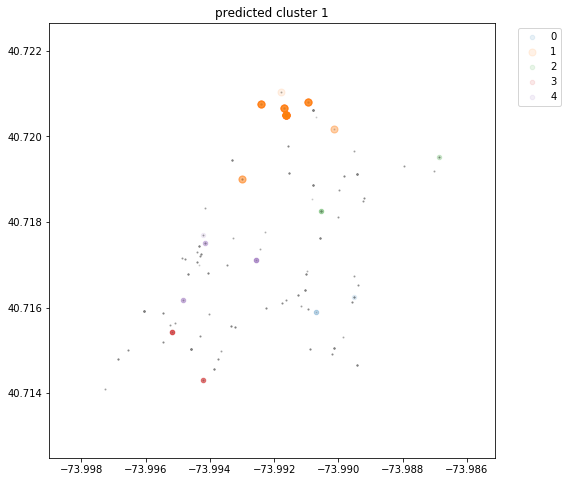

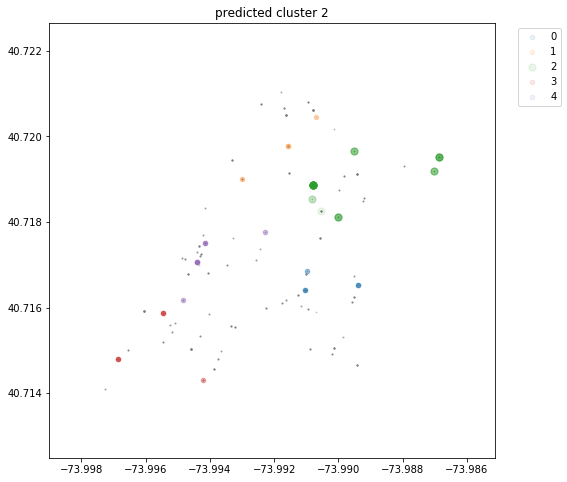

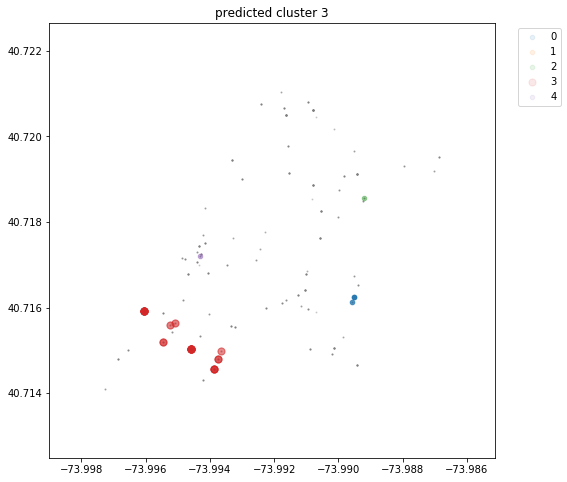

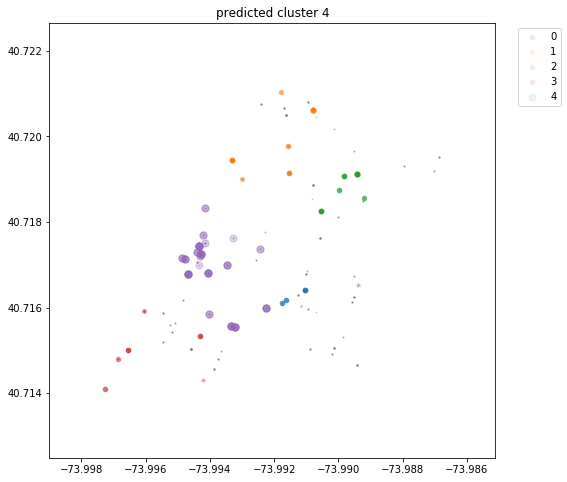

In [20]:
# if self.clusters is None:
#     raise AttributeError("Please run apply clustering first")

cluster_of_centroid = interpolate_sequences.clusters.copy()
ward = 10
cluster = 0
test_df = test


for c in range(5):
    title = 'predicted cluster ' + str(c)
    plot_predictions(cluster_of_centroid, ward, c, test_df, title)

The plot shows all records that are predicted as C cluster. For instance, `predicted cluster 0` plot shows all census records that the model predicts as in cluster 0. The biggest marks are correct prediction. The smaller ones are mispredictions and the grey ones are other Census records that are present in the test data.

In [21]:
test['cluster'].value_counts().sort_index()

0    253
1    226
2    222
3    244
4    272
Name: cluster, dtype: int64

In [22]:
c1 = test.groupby(['cluster', 'pred_cluster'], as_index=False)['CENSUS_SERIALB'].agg('count')
ctotal = test.groupby('cluster', as_index=False)['CENSUS_SERIALB'].agg('count')

c_per = c1.merge(ctotal, how='left', on='cluster')
c_per['percent'] = c_per['CENSUS_SERIALB_x']/c_per['CENSUS_SERIALB_y']*100
c_per.drop(columns=['CENSUS_SERIALB_x', 'CENSUS_SERIALB_y'])
pd.pivot_table(c_per, values='percent', index='cluster',
                    columns=['pred_cluster'], fill_value=0)

pred_cluster,0,1,2,3,4
cluster,,,,,
0,62.450593,1.581028,9.486166,11.067194,15.415020
1,2.654867,45.575221,5.752212,0.000000,46.017699
2,20.720721,2.702703,32.432432,2.252252,41.891892
3,3.278689,6.967213,9.836066,63.934426,15.983607
4,1.102941,6.617647,12.867647,2.205882,77.205882


In each `true_block_cluster`, there are some `pred_block_cluster` that never appear. Most are block clusters that are further from the true block cluster. Would it predict better if there are more block clusters so that there are more clusters not adjacent to the true cluster?

There are around 4-9 blocks per cluster

In [23]:
test.groupby(['cluster', 'block_num'])['CENSUS_SERIALB'].agg('count')

cluster  block_num
0        189.0         55
         190.0         53
         1265.0        12
         1266.0        30
         1267.0        53
         1268.0        50
1        198.0         21
         199.0         24
         201.0        137
         1281.0        15
         1282.0        22
         1283.0         7
2        197.0         31
         202.0         40
         203.0          9
         1274.0        27
         1279.0        54
         1280.0        33
         1284.0         7
         1285.0        21
3        184.0         91
         185.0         63
         186.0         66
         1259.0        24
4        187.0         24
         191.0         25
         192.0        124
         193.0          7
         1260.0        17
         1263.0        30
         1270.0         9
         1271.0        31
         1273.0         5
Name: CENSUS_SERIALB, dtype: int64

## Feature Importance -- target encoded sequences

* enum_dist_id is the strongest feature
* similarity label is strong indicator

In [24]:
importance_df = pd.DataFrame({'feature': interpolate_sequences.model.named_steps["preprocess"].get_feature_names(),
                             'importance': interpolate_sequences.model.named_steps["classifier"].feature_importances_})
cut_importance = importance_df.sort_values('importance').tail(20)

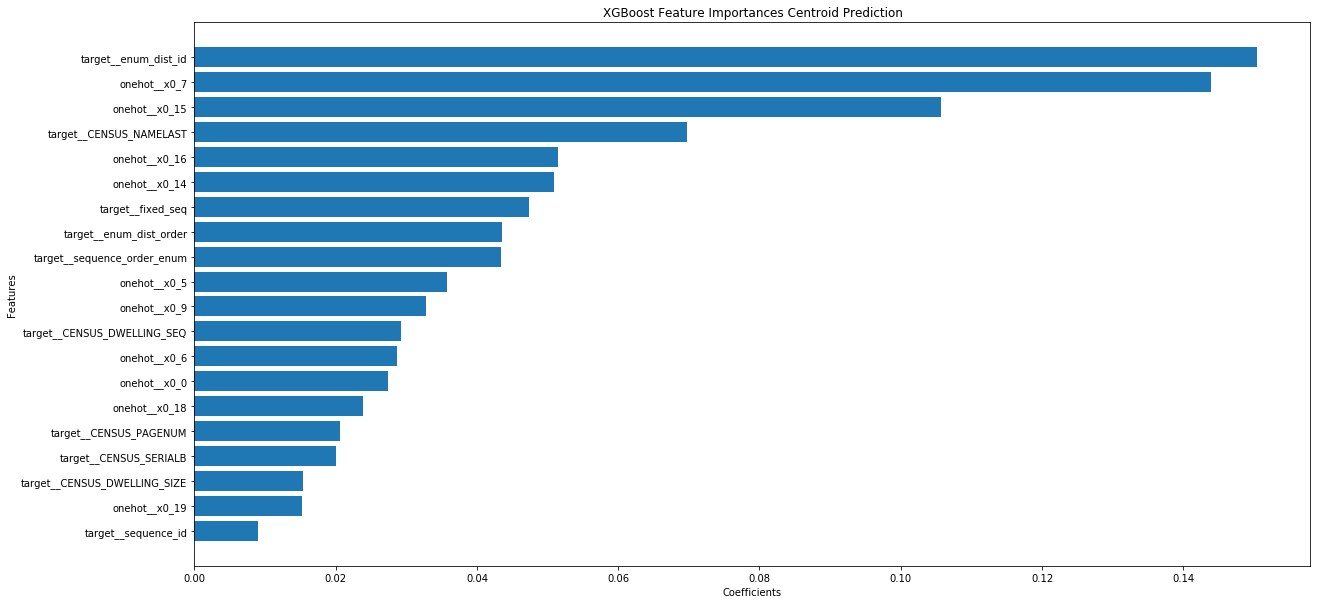

In [25]:
archive.graph_coefs(cut_importance['feature'], 
                    cut_importance['importance'],
                    "XGBoost Feature Importances Centroid Prediction")

## Try with kmeans=7


In [26]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
            "enum_dist_order"]

transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
                                              ('onehot', OneHotEncoder(handle_unknown='ignore'), ['similarity_label'])])
# define pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), 
                           ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                       n_estimators = 50))])

n is 7 and it's the 10th iteration
n is 7 and it's the 20th iteration
n is 7 and it's the 30th iteration
n is 7 and it's the 40th iteration
n is 7 and it's the 50th iteration


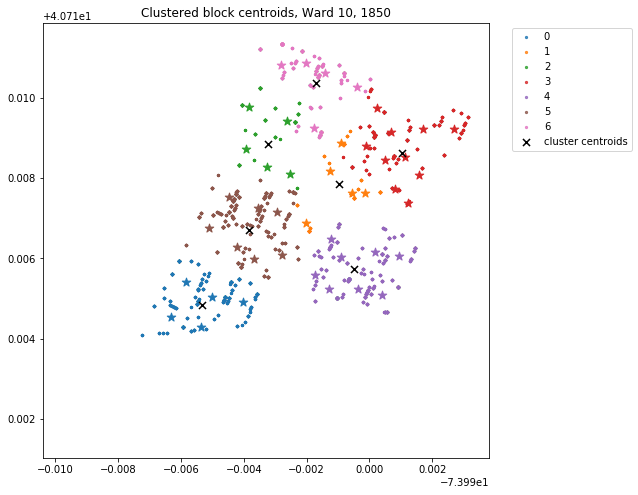

In [27]:
interpolate_sequences_7 = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols + ['similarity_label'],
                                             KMeans(7), block_centroids)
score_7, model_7 = interpolate_sequences_7.kmeans_best(7)
interpolate_sequences_7.set_clustering_algo(model_7)
interpolate_sequences_7.apply_clustering(algo_fit = True)
interpolate_sequences_7.clustervis(kmeans = True)

In [28]:
## retrain model using kmodes result

interpolate_sequences_7.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences_7.train_score).mean())
print('Test score:', interpolate_sequences_7.test_score)
print("avg Test score:", np.array(interpolate_sequences_7.test_score).mean())

Cross Validation
avg Training score: 0.9781657768587019
Test score: [0.590557939914163, 0.5423255813953488, 0.55859375, 0.7141630901287553, 0.5647940074906367, 0.6128747795414462, 0.4742857142857143, 0.6370582617000955, 0.4953775038520801, 0.6795740561471443]
avg Test score: 0.5869604684455385


### Refit the model using this setting (no CV) [CV score of the model is 0.59]

* Similar performance when using k = 7, but has fewer block members in a cluster
* The results from here are used for further analysis.

In [29]:
train_7,test_7 = interpolate_sequences_7.stratified_train_test()
interpolate_sequences_7.train_test_model(train_7, test_7)

In [30]:
print("Training score:",interpolate_sequences_7.train_score)
print("Test score:", interpolate_sequences_7.test_score)

Training score: 0.9813624678663239
Test score: 0.590557939914163


In [31]:
test_7['pred_cluster'] = interpolate_sequences_7.model.predict(test_7)

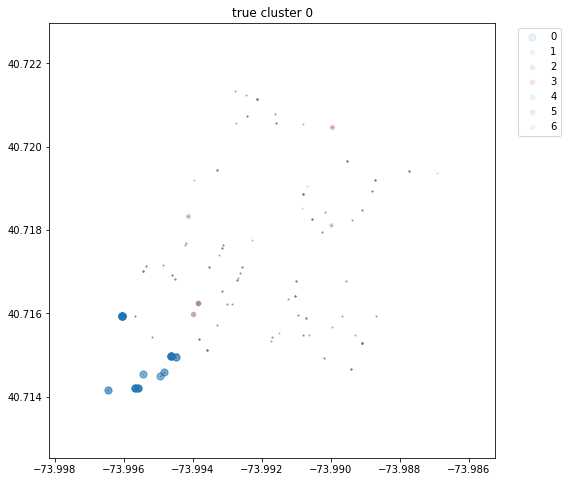

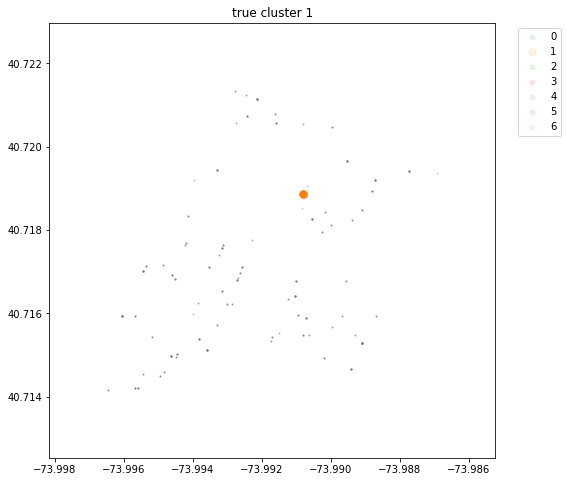

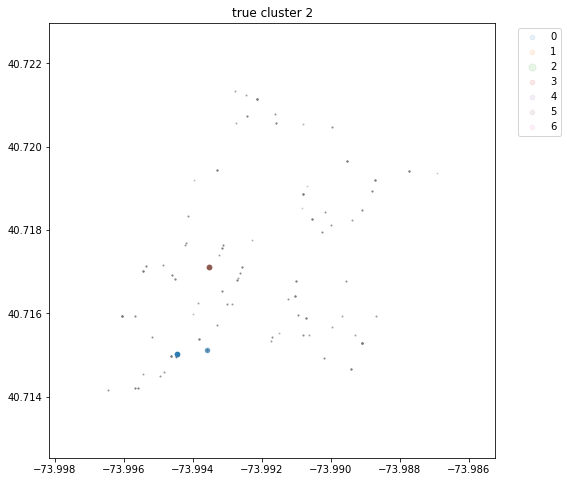

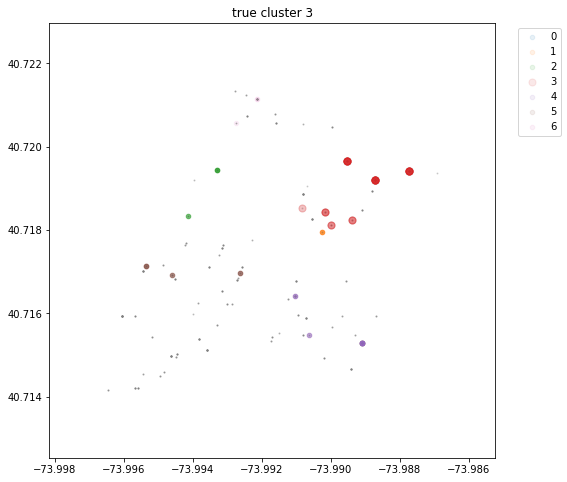

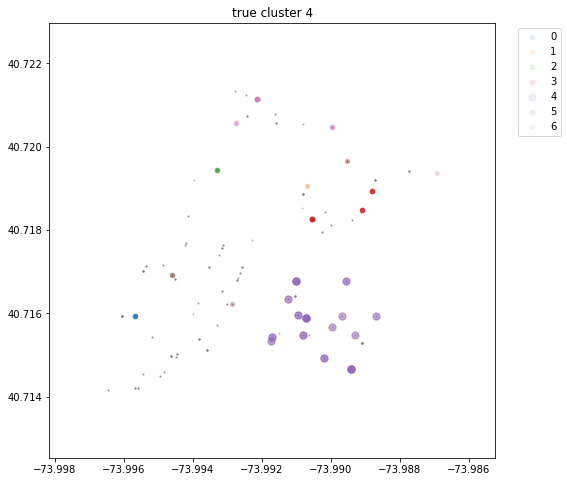

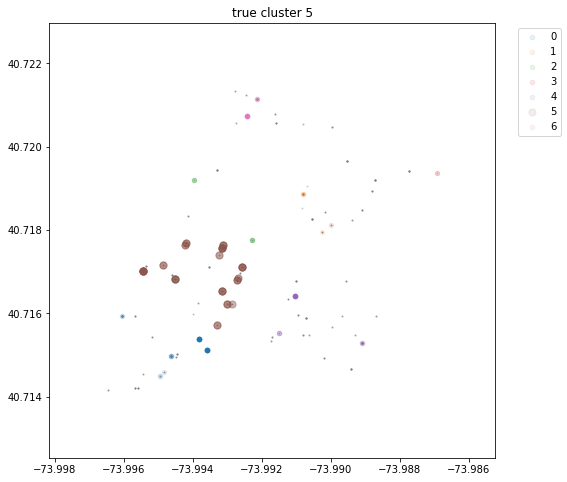

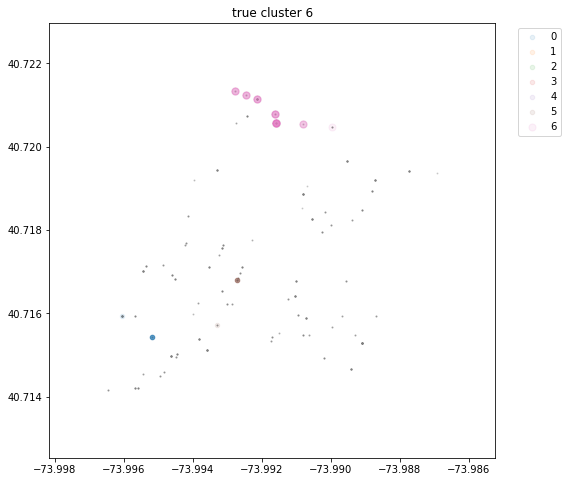

In [32]:
# if self.clusters is None:
#     raise AttributeError("Please run apply clustering first")

cluster_of_centroid = interpolate_sequences_7.clusters.copy()
ward = 10
cluster = 0
test_df = test_7


for c in range(7):
    title = 'true cluster ' + str(c)
    plot_predictions(cluster_of_centroid, ward, c, test_df, title)

There are around ~2-8 blocks per cluster. Only a few in cluster 1.

In [33]:
test_7.groupby(['cluster', 'block_num'])['CENSUS_SERIALB'].agg('count')

cluster  block_num
0        184.0        57
         185.0        61
         186.0        86
         1258.0       40
         1259.0        9
1        1275.0       12
         1280.0       36
2        193.0        14
         199.0        24
         1273.0        5
3        197.0        17
         203.0        44
         1278.0       14
         1279.0       39
         1284.0       27
         1285.0       28
4        188.0        17
         189.0        19
         190.0        24
         195.0        15
         1265.0       19
         1266.0       75
         1267.0       29
         1268.0       64
5        187.0        47
         191.0        92
         192.0        27
         1263.0        8
         1270.0       19
         1271.0       77
6        200.0        20
         201.0        31
         1282.0       57
         1283.0       12
Name: CENSUS_SERIALB, dtype: int64

The plot shows all records that are predicted as C cluster. For instance, `predicted cluster 0` plot shows all census records that the model predicts as in cluster 0. The biggest marks are correct prediction. The smaller ones are mispredictions and the grey ones are other Census records that are present in the test data.


In [34]:
test_7['cluster'].value_counts().sort_index()

0    253
1     48
2     43
3    169
4    262
5    270
6    120
Name: cluster, dtype: int64

In [35]:
c1 = test_7.groupby(['cluster', 'pred_cluster'], as_index=False)['CENSUS_SERIALB'].agg('count')
ctotal = test_7.groupby('cluster', as_index=False)['CENSUS_SERIALB'].agg('count')

c_per = c1.merge(ctotal, how='left', on='cluster')
c_per['percent'] = c_per['CENSUS_SERIALB_x']/c_per['CENSUS_SERIALB_y']*100
c_per.drop(columns=['CENSUS_SERIALB_x', 'CENSUS_SERIALB_y'])
pd.pivot_table(c_per, values='percent', index='cluster',
                    columns=['pred_cluster'], fill_value=0)

pred_cluster,0,1,2,3,4,5,6
cluster,,,,,,,
0,56.521739,0.0,9.486166,0.000000,5.138340,24.505929,4.347826
1,0.000000,62.5,0.000000,22.916667,6.250000,8.333333,0.000000
2,4.651163,0.0,0.000000,53.488372,20.930233,20.930233,0.000000
3,0.591716,0.0,0.000000,61.538462,36.094675,1.775148,0.000000
4,0.000000,0.0,0.000000,24.045802,65.267176,10.687023,0.000000
5,4.074074,0.0,7.037037,12.962963,3.703704,68.888889,3.333333
6,3.333333,0.0,0.000000,2.500000,31.666667,17.500000,45.000000


## Feature Importance -- target encoded sequences

* similarity label and sequences are strong indicator


In [36]:
importance_df_7 = pd.DataFrame({'feature': interpolate_sequences_7.model.named_steps["preprocess"].get_feature_names(),
                             'importance': interpolate_sequences_7.model.named_steps["classifier"].feature_importances_})
cut_importance_7 = importance_df_7.sort_values('importance').tail(20)

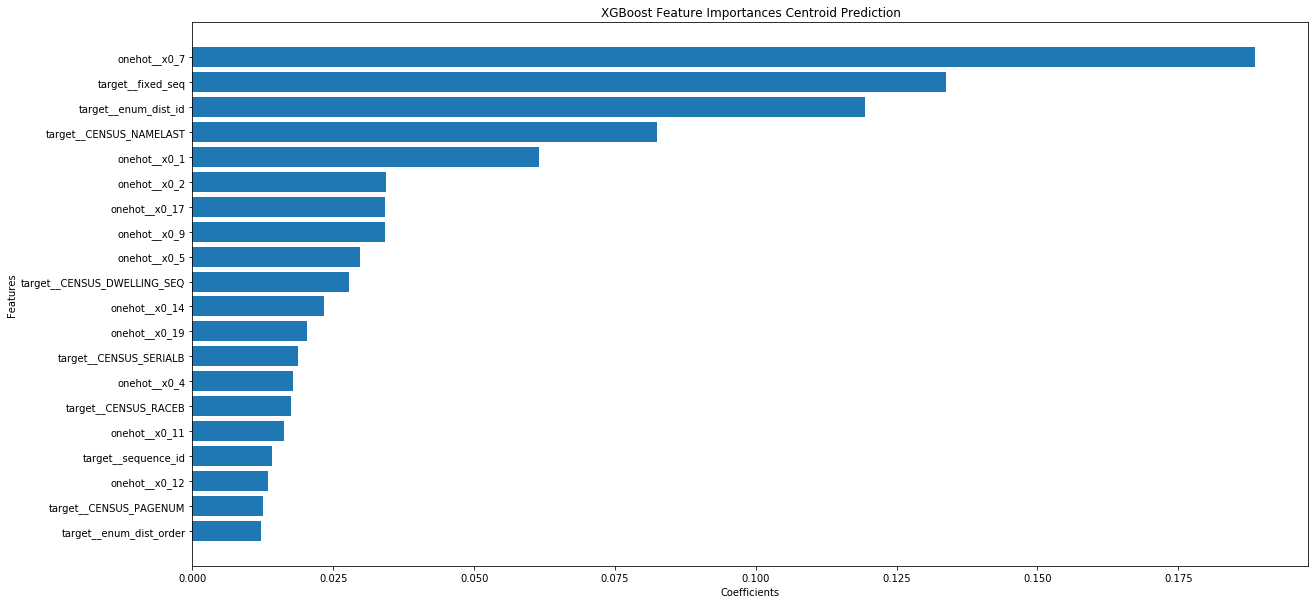

In [37]:
archive.graph_coefs(cut_importance_7['feature'], 
                    cut_importance_7['importance'],
                    "XGBoost Feature Importances Centroid Prediction")

## How similary are two records that are correctly and wrongly classified?

### In cluster 2 - block num 192

* Although sequences and similarity are strong, the classification is still highly influenced by other features (see index 284, 288)

In [38]:
test_7.reset_index(inplace=True)
test_7.loc[(test_7['cluster']==2) & (test_7['pred_cluster']!=2)][similar_cols + ['similarity_label', 'cluster', 'pred_cluster', 'block_num']].drop_duplicates()

,sequence_id,dwelling_seq_id,fixed_seq,enum_dist_id,similarity_label,cluster,pred_cluster,block_num
284,557.0,0.0,13,557,0,2,3,193.0
288,557.0,0.0,13,557,0,2,0,193.0
377,859.0,0.0,20,852,0,2,5,193.0
645,1261.0,1043.0,30,Ward_Num,6,2,4,199.0
651,1261.0,1043.0,30,Ward_Num,6,2,3,199.0
1087,1859.0,1043.0,44,1859,1,2,5,1273.0


In [40]:
pd.set_option('display.max_columns', None)
test_7.iloc[[284,288],:][all_cols + similar_cols + ['similarity_label', 'cluster', 'pred_cluster', 'block_num']].drop_duplicates()

,CENSUS_SERIALB,CENSUS_AGE,CENSUS_PAGENUM,CENSUS_SEXB,CENSUS_RACEB,sequence_id,CENSUS_DWELLING_SIZE,CENSUS_SEQ_NUM,CENSUS_LABFORCE,CENSUS_LINE,CENSUS_MARST,CENSUS_NAMEFRST,CENSUS_NAMELAST,CENSUS_OCCSTR,CENSUS_IMPREL,sequence_order_enum,CENSUS_DWELLING_SEQ,dwelling_seq_id,fixed_seq,enum_dist_id,enum_dist_order,sequence_id,dwelling_seq_id,fixed_seq,enum_dist_id,similarity_label,cluster,pred_cluster,block_num
284,2087197,35,1490,1,120,557.0,4,1,2,330,1,GEORGE T,CLARK,ENGINEER,1,48.0,1306.0,0.0,13,557,2.0,557.0,0.0,13,557,0,2,3,193.0
288,2087198,35,1490,2,120,557.0,2,1,0,370,6,SUSAN A,WATTS,NaN,1,48.0,1307.0,0.0,13,557,2.0,557.0,0.0,13,557,0,2,0,193.0


It is strange how close the two records are but still being classified to different clusters

### In cluster 4 - block num 186

* similar analysis to of cluster 2

In [41]:
test_7.reset_index(inplace=True)
test_7.loc[(test_7['cluster']==4) & (test_7['pred_cluster']!=4)][similar_cols + ['similarity_label', 'cluster', 'pred_cluster', 'block_num']].drop_duplicates()

,sequence_id,dwelling_seq_id,fixed_seq,enum_dist_id,similarity_label,cluster,pred_cluster,block_num
294,596.0,0.0,13,596,0,4,3,1268.0
315,596.0,0.0,14,596,17,4,3,189.0
462,1054.0,1043.0,25,1054,1,4,5,1266.0
465,1054.0,1043.0,25,1054,1,4,3,1266.0
586,1112.0,1043.0,27,1112,1,4,5,1268.0
1092,1859.0,1043.0,45,1859,1,4,5,188.0


In [42]:
pd.set_option('display.max_columns', None)
test_7.iloc[[462,465],:][all_cols + similar_cols + ['similarity_label', 'cluster', 'pred_cluster', 'block_num']].drop_duplicates()

,CENSUS_SERIALB,CENSUS_AGE,CENSUS_PAGENUM,CENSUS_SEXB,CENSUS_RACEB,sequence_id,CENSUS_DWELLING_SIZE,CENSUS_SEQ_NUM,CENSUS_LABFORCE,CENSUS_LINE,CENSUS_MARST,CENSUS_NAMEFRST,CENSUS_NAMELAST,CENSUS_OCCSTR,CENSUS_IMPREL,sequence_order_enum,CENSUS_DWELLING_SEQ,dwelling_seq_id,fixed_seq,enum_dist_id,enum_dist_order,sequence_id,dwelling_seq_id,fixed_seq,enum_dist_id,similarity_label,cluster,pred_cluster,block_num
462,2088322,34,2850,1,120,1054.0,51,1,2,210,1,R DE,GRAY,MARINER,1,91.0,13.0,1043.0,25,1054,1.0,1054.0,1043.0,25,1054,1,4,5,1266.0
465,2088322,34,2850,1,120,1054.0,51,4,2,210,1,JOHN J,WINTERS,MERCHANT,12,91.0,13.0,1043.0,25,1054,1.0,1054.0,1043.0,25,1054,1,4,3,1266.0


## Is this the result from target encoding the sequences?

My initial idea was that target encoding sequences imposes numerical values to centroid clusters. However, doing this somehow produces better result than one hot encoding sequences (**see next section**).

* [updated] Target encoding somehow produces better result. Keep it as is.
* [outdated] could it be why sequences, and consequently similarity, are not strong indicator of block cluster?
* [outdated] Treating as numerical should not be a problem bc we use XGBoost which is non-linear. The problem is when the same value of a feature points to different clusters. This happens due to using *TargetEncode*.

## One hot encoded sequences, k=7 [underperform target encoding]

In [43]:
for c in similar_cols:
    print('unique values of {}: {}'.format(c, interpolate_sequences.df[c].unique().shape[0]))

unique values of sequence_id: 169
unique values of dwelling_seq_id: 2
unique values of fixed_seq: 49
unique values of enum_dist_id: 163


There are total of ~380 levels of features. Treating them all as categorical values (not using TargetEncode) will add ~380 more columns to the dataframe. This should be insignificant compared to the number of records in the dataframe.

In [44]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
             "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "enum_dist_order"]

one_hot_cols = ["sequence_id", "dwelling_seq_id", "fixed_seq", "enum_dist_id", 'similarity_label']
transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
                                              ('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_cols)])
# define pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), 
                           ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                       n_estimators = 50))])

In [47]:
## convert one hot columns to str for preprocessing
census_enum_seq.df[one_hot_cols].dtypes
for c in one_hot_cols:
    census_enum_seq.df[c] = census_enum_seq.df[c].astype(str)
census_enum_seq.df[one_hot_cols].dtypes

sequence_id         object
dwelling_seq_id     object
fixed_seq           object
enum_dist_id        object
similarity_label    object
dtype: object

n is 7 and it's the 10th iteration
n is 7 and it's the 20th iteration
n is 7 and it's the 30th iteration
n is 7 and it's the 40th iteration
n is 7 and it's the 50th iteration


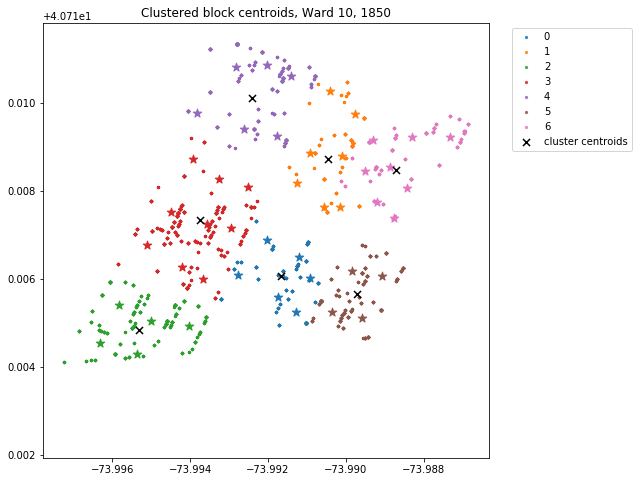

In [48]:
interpolate_sequences_onehot = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols + one_hot_cols,
                                             KMeans(7), block_centroids)
score_onehot, model_onehot = interpolate_sequences_onehot.kmeans_best(7)
interpolate_sequences_onehot.set_clustering_algo(model_onehot)
interpolate_sequences_onehot.apply_clustering(algo_fit = True)
interpolate_sequences_onehot.clustervis(kmeans = True)

Worse performance.

In [49]:
## retrain model using kmodes result

interpolate_sequences_onehot.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences_onehot.train_score).mean())
print('Test score:', interpolate_sequences_onehot.test_score)
print("avg Test score:", np.array(interpolate_sequences_onehot.test_score).mean())

Cross Validation
avg Training score: 0.9484094972991987
Test score: [0.5129240710823909, 0.5381426202321725, 0.5050741608118657, 0.5750224618149147, 0.5931098696461825, 0.5450917797286512, 0.552099533437014, 0.5435801312089972, 0.5198275862068965, 0.49182879377431904]
avg Test score: 0.5376701007943405


## Feature Importance - one hot sequences - k = 7

* some ids of `sequence_id` (x0) and `fixed_seq` (x3) appear in the top 20 important features

In [ ]:
from interpolation import archive

In [50]:
importance_df_onehot = pd.DataFrame({'feature': interpolate_sequences_onehot.model.named_steps["preprocess"].get_feature_names(),
                             'importance': interpolate_sequences_onehot.model.named_steps["classifier"].feature_importances_})
cut_importance_onehot = importance_df_onehot.sort_values('importance').tail(20)

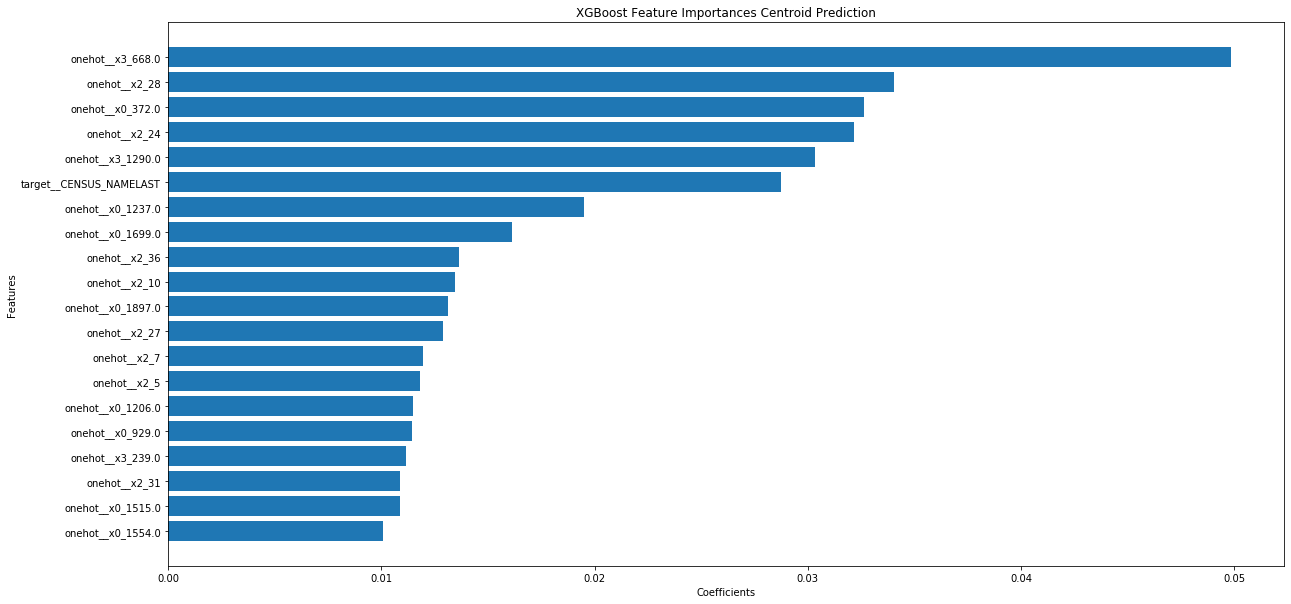

In [51]:
archive.graph_coefs(cut_importance_onehot['feature'], 
                    cut_importance_onehot['importance'],
                    "XGBoost Feature Importances Centroid Prediction")

In [53]:
for i in range(5):
    print('x{}: {}'.format(i, one_hot_cols[i]))

x0: sequence_id
x1: dwelling_seq_id
x2: fixed_seq
x3: enum_dist_id
x4: similarity_label
